# Salary.com Data Scraper

extract salary information for specific job titles in the 317 largest us cities

In [1]:
import csv
from time import sleep
import json
import requests
from bs4 import BeautifulSoup
import re

## Identify scraping methodology

- Website: https://www.salary.com/



**URL Pattern**  
What you should see now is a curve representing the distribution of salaries, with markers at the quintiles. 
- The  "view as table" link gives us acess to the data in table form, which is what we want to scrape. 
- The pattern of the url we want to scrape had /alternate.
- The job title is at the end of the url with the word salary appended to the end  


In [2]:
template = 'https://www.salary.com/research/salary/alternate/{}-salary/{}'

Now, use the template you just created to create a url. Then send a get request to extract the raw html from the website.

In [8]:
# build the url based on search criteria
position = 'lawyer-ii'
city = 'charlotte-nc'




url = template.format(position, city)
print(url)
# request the raw html
response = requests.get(url)

print(response)

https://www.salary.com/research/salary/alternate/lawyer-ii-salary/charlotte-nc
<Response [200]>


### json formatted data
We are looking for the json formatted data that is embedded in the html data. When we right-clicked on the web-page and then click "view page source", we notice some clearly formatted json data, that we can extract from the page, formatted as a python dictionary. This made it much easier for us because they also had the quantiles sepcifically broken down.

### Extracting the script
The script tag we need has a specific type, "application/ld+json," narrowing down the options. However, upon closer inspection of these scripts, we noticed they contain an "@Type" key, with one being labeled "Occupation" and the other "Organization." This aligns with the comments mentioned earlier. To pinpoint the exact script, we implemented a basic regular expression pattern that specifically looks for the presence of the word "Organization."

In [9]:
soup = BeautifulSoup(response.text, 'html.parser')

template = 'https://www.salary.com/research/salary/alternate/{}-salary/{}'

In [10]:



pattern = re.compile(r'Occupation')

script = soup.find('script', {'type': 'application/ld+json'}, text=pattern)



C:\Users\Reason\AppData\Local\Temp\ipykernel_11232\3560943654.py:3: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  script = soup.find('script', {'type': 'application/ld+json'}, text=pattern)


In [11]:
script

<script type="application/ld+json">
 {
    "@context": "http://schema.org",
    "@type": "Occupation",
    "name": "Lawyer II",
    "mainEntityOfPage": {
        "@type": "WebPage",
        "lastReviewed": "2023-11-27T00:00:00Z"
    },
    "description": "The Lawyer II provides legal advice to an organization, prepares resolutions, reports, guidelines and participates in major legal actions. Reviews contracts involving leases, licenses, purchases, sales, insurance, etc., and reviews the drafts of various agreements and documents. Being a Lawyer II participates in Legal department initiatives such as template agreement development and recommends to senior management on how to respond to legal issues or proposed changes in laws and regulations. Works closely with other departments to foresee and protect company against legal risks. In addition, Lawyer II requires a Juris Doctor degree from an accredited law school and may require admittance to a state bar. Typically reports to a manager 

In [13]:
json_raw = script.contents[0]

### Convert the json data
Now that we have a raw json string, we need to convert it to a python dictionary. We'll do this by using the `loads` function in the `json` library.

In [14]:
json_data = json.loads(json_raw)

In [15]:
json_data

{'@context': 'http://schema.org',
 '@type': 'Occupation',
 'name': 'Lawyer II',
 'mainEntityOfPage': {'@type': 'WebPage',
  'lastReviewed': '2023-11-27T00:00:00Z'},
 'description': 'The Lawyer II provides legal advice to an organization, prepares resolutions, reports, guidelines and participates in major legal actions. Reviews contracts involving leases, licenses, purchases, sales, insurance, etc., and reviews the drafts of various agreements and documents. Being a Lawyer II participates in Legal department initiatives such as template agreement development and recommends to senior management on how to respond to legal issues or proposed changes in laws and regulations. Works closely with other departments to foresee and protect company against legal risks. In addition, Lawyer II requires a Juris Doctor degree from an accredited law school and may require admittance to a state bar. Typically reports to a manager or head of a unit/department. Being a Lawyer II occasionally directed in s

### Extracting the data
Now that we have a python dictionary, we can index as you would a normal dictionary. So, let's grab the job title, the description, location, and the base compensation statistics.

In [18]:
job_title = json_data['name']
location = json_data['occupationLocation'][0]['name']
description = json_data['description']

ntile_10 = json_data['estimatedSalary'][0]['percentile10']
ntile_25 = json_data['estimatedSalary'][0]['percentile25']
ntile_50 = json_data['estimatedSalary'][0]['median']
ntile_75 = json_data['estimatedSalary'][0]['percentile75']
ntile_90 = json_data['estimatedSalary'][0]['percentile90']

salary_data = (job_title, location, description, ntile_10, ntile_25, ntile_50, ntile_75, ntile_90)
print(salary_data)

('Lawyer II', 'Charlotte, NC', 'The Lawyer II provides legal advice to an organization, prepares resolutions, reports, guidelines and participates in major legal actions. Reviews contracts involving leases, licenses, purchases, sales, insurance, etc., and reviews the drafts of various agreements and documents. Being a Lawyer II participates in Legal department initiatives such as template agreement development and recommends to senior management on how to respond to legal issues or proposed changes in laws and regulations. Works closely with other departments to foresee and protect company against legal risks. In addition, Lawyer II requires a Juris Doctor degree from an accredited law school and may require admittance to a state bar. Typically reports to a manager or head of a unit/department. Being a Lawyer II occasionally directed in several aspects of the work. Gains exposure to some of the complex tasks within the job function. Working as a Lawyer II typically requires 2 -4 years 

### Expanding your data set
We only have data for a single city, so we will expand it to the largest 
Having this data for a single city is nice, but wouldn't it be nice to compare the salary statistics for the same position for the largest cities in the united states?  This is exactly what we're going to do next. But, first, let's go ahead and generalize what we've done so far in a function, so that we can apply it to a long list of cities that we'd like to extract data for.

In [47]:
def extract_salary_info(job_title, job_city):
    """Extract and return salary information"""
    template = 'https://www.salary.com/research/salary/alternate/{}-salary/{}'
 
    # build the url based on search criteria
    url = template.format(job_title, job_city)

    # request the raw html .. check for valid request
    try:
        response = requests.get(url)
        if response.status_code != 200:
            return None
    except requests.exceptions.ConnectionError:
        return None
   
    # parse the html and extract json data
    soup = BeautifulSoup(response.text, 'html.parser')
    pattern = re.compile(r'Occupation')
    script = soup.find('script', {'type': 'application/ld+json'}, text=pattern)
    json_raw = script.contents[0]
    json_data = json.loads(json_raw)

    # extract salary data
    job_title = json_data['name']
    location = json_data['occupationLocation'][0]['name']
    description = json_data['description']

    ntile_10 = json_data['estimatedSalary'][0]['percentile10']
    ntile_25 = json_data['estimatedSalary'][0]['percentile25']
    ntile_50 = json_data['estimatedSalary'][0]['median']
    ntile_75 = json_data['estimatedSalary'][0]['percentile75']
    ntile_90 = json_data['estimatedSalary'][0]['percentile90']

    data = (job_title, location, description, ntile_10, ntile_25, ntile_50, ntile_75, ntile_90)
    return data

Now, let's import a list of cities. I found a list of the top 300+ US cities on Wikipedia, and then I re-formatted the city and state name so that I could easily insert it into this function and url.

In [100]:
with open('largest_cities.csv', newline='') as f:
    reader = csv.reader(f)
    # a reader typically returns each row as a list... so I need to flatten the list to make a single list
    cities = [city for row in reader for city in row]

In [26]:
with open('us_states.csv',newline = '') as f:
    reader = csv.reader(f)
    
    states = [state for row in reader for state in row]

In [46]:
import pandas as pd


states = pd.read_csv('us_states.csv')
display(states.iloc[:,0])

0            Alabama
1             Alaska
2            Arizona
3           Arkansas
4         California
5           Colorado
6        Connecticut
7           Delaware
8            Florida
9            Georgia
10            Hawaii
11             Idaho
12          Illinois
13           Indiana
14              Iowa
15            Kansas
16          Kentucky
17         Louisiana
18             Maine
19          Maryland
20     Massachusetts
21          Michigan
22         Minnesota
23       Mississippi
24          Missouri
25           Montana
26          Nebraska
27            Nevada
28     New Hampshire
29        New Jersey
30        New Mexico
31          New York
32    North Carolina
33      North Dakota
34              Ohio
35          Oklahoma
36            Oregon
37      Pennsylvania
38      Rhode Island
39    South Carolina
40      South Dakota
41         Tennessee
42             Texas
43              Utah
44           Vermont
45          Virginia
46        Washington
47     West V

### Getting all city data
Now I an iterate over each major city in the US, extract the relevant salary information. I'm going to use the sleep function to create a small delay between each request. 

In [92]:
salary_data = []
surgeon_types = [
    "general-surgeon",
    "cardiothoracic-surgeon",
    "neurological-surgeon",
    "oral-surgeon",
    "orthopedic-surgeon",
    "burn-surgeon"
]






for state in states.iloc[:,1]:
    for surgeon in surgeon_types:
        result = extract_salary_info(surgeon, state)
        if result:
            salary_data.append(result)
            #sleep(0.5)


C:\Users\Reason\AppData\Local\Temp\ipykernel_11232\1842933549.py:19: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  script = soup.find('script', {'type': 'application/ld+json'}, text=pattern)


### Save the data to csv
Finally, we'll save our data to a csv file. 

In [94]:
with open('salary-results_states.csv', 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(['Title','Location', 'Description', 'nTile10', 'nTile25', 'nTile50', 'nTile75', 'nTile90'])
    writer.writerows(salary_data)

In [93]:
# print the first 5 records
for row in salary_data[:5]:
    print(row)

('General Surgeon', 'Alabama', 'The General Surgeon reviews patient history and confirms need for surgery. Performs surgery to prevent and correct injuries, deformities, diseases or improve patient function, appearance or quality of life. Being a General Surgeon may provide medical personnel with direction concerning patient care. Determines which instruments and method of surgery will be most successful in achieving desired outcome. In addition, General Surgeon may provide in-service training as needed to address new technology in health care treatment. Provides charting in compliance with all laws and regulations. Requires a special degree in medicine from an accredited school. Typically reports to a medical director. Requires a license to practice. General Surgeon&#39;s years of experience requirement may be unspecified. Certification and/or licensing in the position&#39;s specialty is the main requirement.', '280190', '336000', '397300', '471500', '539055')
('Cardiothoracic Surgeon

### Consolidate into main function

In [96]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Read the CSV file into a Pandas DataFrame
df_sample = pd.read_csv('salary-results_states.csv')
# Dictionary mapping state names to abbreviations
state_to_abbreviation = {
    "Alabama": "AL", "Alaska": "AK", "Arizona": "AZ", "Arkansas": "AR",
    "California": "CA", "Colorado": "CO", "Connecticut": "CT", "Delaware": "DE",
    "Florida": "FL", "Georgia": "GA", "Hawaii": "HI", "Idaho": "ID",
    "Illinois": "IL", "Indiana": "IN", "Iowa": "IA", "Kansas": "KS",
    "Kentucky": "KY", "Louisiana": "LA", "Maine": "ME", "Maryland": "MD",
    "Massachusetts": "MA", "Michigan": "MI", "Minnesota": "MN", "Mississippi": "MS",
    "Missouri": "MO", "Montana": "MT", "Nebraska": "NE", "Nevada": "NV",
    "New Hampshire": "NH", "New Jersey": "NJ", "New Mexico": "NM", "New York": "NY",
    "North Carolina": "NC", "North Dakota": "ND", "Ohio": "OH", "Oklahoma": "OK",
    "Oregon": "OR", "Pennsylvania": "PA", "Rhode Island": "RI", "South Carolina": "SC",
    "South Dakota": "SD", "Tennessee": "TN", "Texas": "TX", "Utah": "UT",
    "Vermont": "VT", "Virginia": "VA", "Washington": "WA", "West Virginia": "WV",
    "Wisconsin": "WI", "Wyoming": "WY"
}
salary_columns = ['nTile10', 'nTile25', 'nTile50', 'nTile75', 'nTile90']

# Add a new column for state abbreviations in the DataFrame
df_sample['State Abbreviation'] = df_sample['Location'].map(state_to_abbreviation)


    # Extracting only the salary quintile columns and converting each row into a list
salary_lists = df_sample[salary_columns].values.tolist()

# Keeping the states associated with each list
states = df_sample['Location'].values

# Creating an array where each element is a tuple (state, list_of_salary_quintiles)
state_salary_arrays = [(state, salaries) for state, salaries in zip(states, salary_lists)]










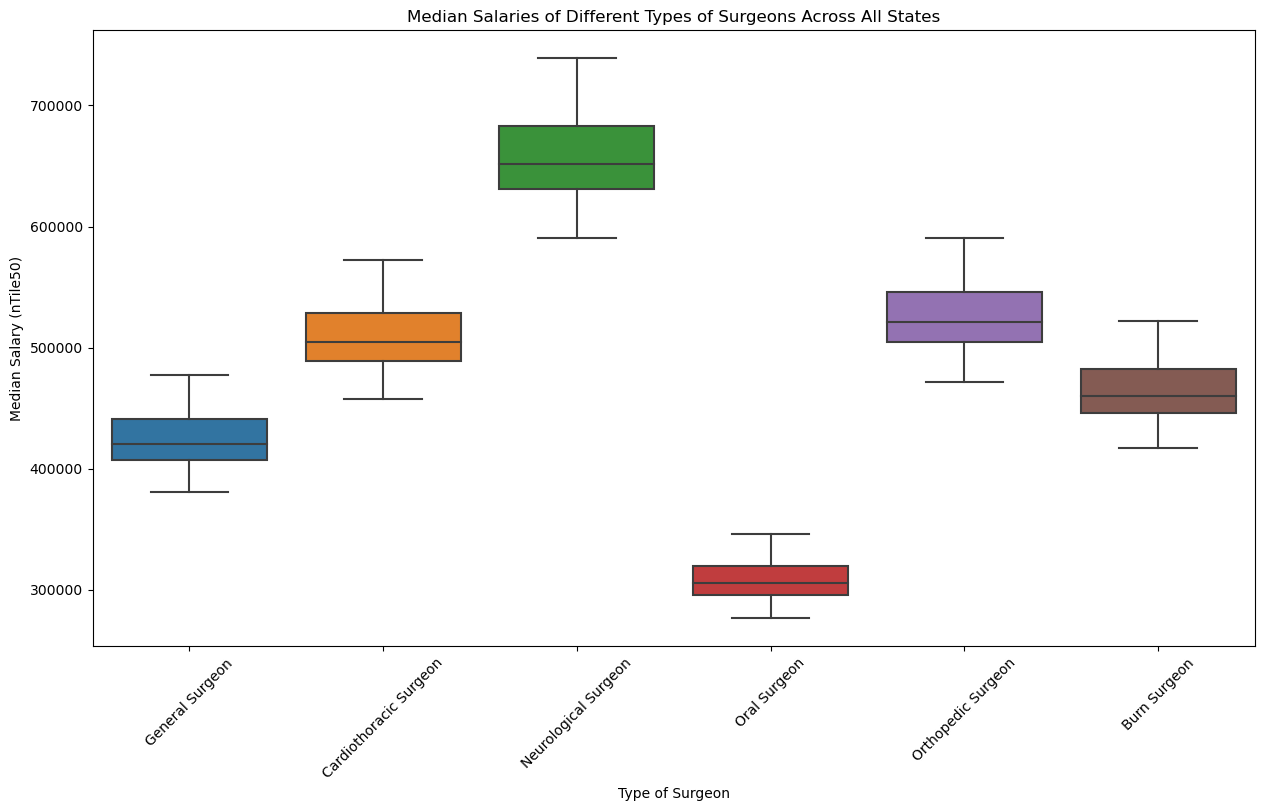

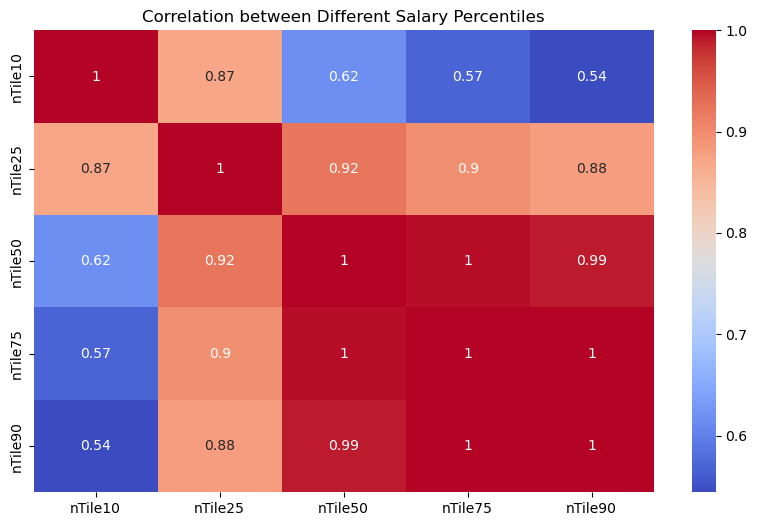

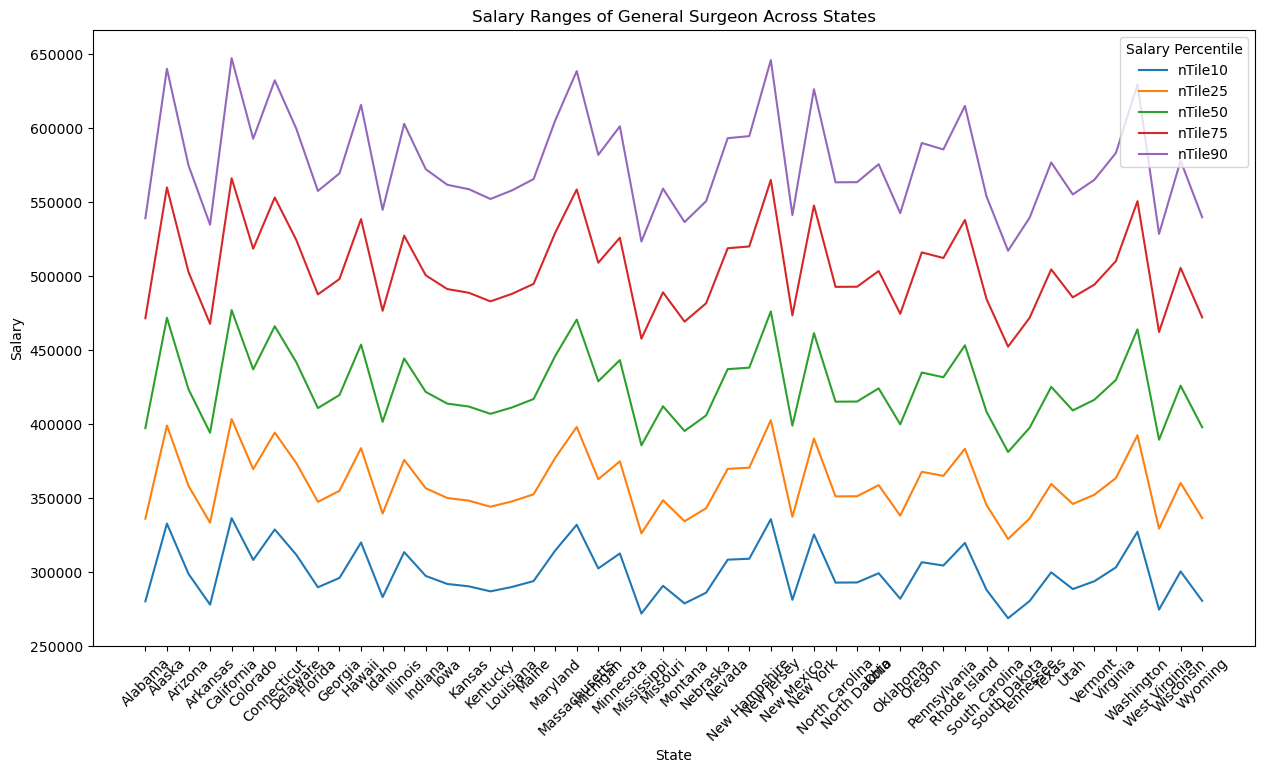

In [99]:
# Based on the structure of the data, we can create insightful graphs that follow the rubric requirements.
# The graphs will focus on visualizing differences in salaries among various types of surgeons across different states.
df_surgeon_salary = pd.read_csv('salary-results_states.csv')
# Graph 1: Box plots for median salaries of different types of surgeons across all states
plt.figure(figsize=(15, 8))
sns.boxplot(x='Title', y='nTile50', data=df_surgeon_salary)
plt.xticks(rotation=45)
plt.title('Median Salaries of Different Types of Surgeons Across All States')
plt.xlabel('Type of Surgeon')
plt.ylabel('Median Salary (nTile50)')
plt.show()

# Graph 2: Heatmap showing the correlation between different salary percentiles
plt.figure(figsize=(10, 6))
sns.heatmap(df_surgeon_salary[['nTile10', 'nTile25', 'nTile50', 'nTile75', 'nTile90']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation between Different Salary Percentiles')
plt.show()

# Graph 3: Line plot showing the trend of salary ranges for a selected type of surgeon across states
# Selecting a specific type of surgeon for illustration
selected_surgeon_type = 'General Surgeon'
df_selected_surgeon = df_surgeon_salary[df_surgeon_salary['Title'] == selected_surgeon_type]

plt.figure(figsize=(15, 8))
for percentile in ['nTile10', 'nTile25', 'nTile50', 'nTile75', 'nTile90']:
    sns.lineplot(x='Location', y=percentile, data=df_selected_surgeon, label=percentile)
plt.xticks(rotation=45)
plt.title(f'Salary Ranges of {selected_surgeon_type} Across States')
plt.xlabel('State')
plt.ylabel('Salary')
plt.legend(title='Salary Percentile')
plt.show()


In [102]:
with open('largest_cities.csv', newline='') as f:
    reader = csv.reader(f)
    # a reader typically returns each row as a list... so I need to flatten the list to make a single list
    cities = [city for row in reader for city in row]
    

['New-York-NY',
 'Los-Angeles-CA',
 'Chicago-IL',
 'Houston-TX',
 'Phoenix-AZ',
 'Philadelphia-PA',
 'San-Antonio-TX',
 'San-Diego-CA',
 'Dallas-TX',
 'San-Jose-CA',
 'Austin-TX',
 'Jacksonville-FL',
 'Fort-Worth-TX',
 'Columbus-OH',
 'Charlotte-NC',
 'San-Francisco-CA',
 'Indianapolis-IN',
 'Seattle-WA',
 'Denver-CO',
 'Washington-DC',
 'Boston-MA',
 'El-Paso-TX',
 'Nashville-TN',
 'Detroit-MI',
 'Oklahoma-City-OK',
 'Portland-OR',
 'Las-Vegas-NV',
 'Memphis-TN',
 'Louisville-KY',
 'Baltimore-MD',
 'Milwaukee-WI',
 'Albuquerque-NM',
 'Tucson-AZ',
 'Fresno-CA',
 'Mesa-AZ',
 'Sacramento-CA',
 'Atlanta-GA',
 'Kansas-City-MO',
 'Colorado-Springs-CO',
 'Omaha-NE',
 'Raleigh-NC',
 'Miami-FL',
 'Long-Beach-CA',
 'Virginia-Beach-VA',
 'Oakland-CA',
 'Minneapolis-MN',
 'Tulsa-OK',
 'Tampa-FL',
 'Arlington-TX',
 'New-Orleans-LA',
 'Wichita-KS',
 'Bakersfield-CA',
 'Cleveland-OH',
 'Aurora-CO',
 'Anaheim-CA',
 'Honolulu-HI',
 'Santa-Ana-CA',
 'Riverside-CA',
 'Corpus-Christi-TX',
 'Lexington-KY'

In [104]:
salary_data = []


surgeon_types = [
    "general-surgeon",
    "cardiothoracic-surgeon",
    "neurological-surgeon",
    "oral-surgeon",
    "orthopedic-surgeon",
    "burn-surgeon"
]


for city in cities:
    for surgeon in surgeon_types:
        result = extract_salary_info(surgeon, city)
        if result:
            salary_data.append(result)
            #sleep(0.5)



C:\Users\Reason\AppData\Local\Temp\ipykernel_11232\1842933549.py:19: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  script = soup.find('script', {'type': 'application/ld+json'}, text=pattern)


In [105]:
with open('salary-results_cities.csv', 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(['Title','Location', 'Description', 'nTile10', 'nTile25', 'nTile50', 'nTile75', 'nTile90'])
    writer.writerows(salary_data)

## Geocoder to find the geographic locatio nof these cities to show the hot places

In [ ]:
import geocoder

df_surgeon_salary_cities = pd.read_csv('salary-results_cities.csv')

display(df_surgeon_salary_cities.head())

# Define a function to get latitude and longitude
def get_lat_lng(location):
    g = geocoder.osm(location)
    if g.latlng:
        return g.latlng
    else:
        return (None, None)

# Apply the function to each row in the DataFrame
df_surgeon_salary_cities['Coordinates'] = df_surgeon_salary_cities['Location'].apply(get_lat_lng)

# Split the coordinates into two separate columns
df_surgeon_salary_cities['Latitude'] = df_surgeon_salary_cities['Coordinates'].apply(lambda x: x[0] if x else None)
df_surgeon_salary_cities['Longitude'] = df_surgeon_salary_cities['Coordinates'].apply(lambda x: x[1] if x else None)

# Drop the temporary Coordinates column
df_surgeon_salary_cities = df_surgeon_salary_cities.drop(columns=['Coordinates'])

# Display the updated DataFrame
print(df_surgeon_salary_cities.head())

,Title,Location,Description,nTile10,nTile25,nTile50,nTile75,nTile90
0,General Surgeon,"New York, NY",The General Surgeon reviews patient history an...,358321,429700,508100,603000,689401
1,Cardiothoracic Surgeon,"New York, NY",The Cardiothoracic Surgeon determines which in...,378536,488700,609700,764300,905055
2,Neurological Surgeon,"New York, NY",The Neurological Surgeon operates on the brain...,415518,592600,787100,996000,1186193
3,Oral Surgeon,"New York, NY",The Oral Surgeon reviews patient history and c...,322467,344500,368700,402700,433655
4,Orthopedic Surgeon,"New York, NY",The Orthopedic Surgeon performs surgical proce...,372209,494710,629260,814070,982330


## Displaying the locations of the salaries below is median salary for roles per city


In [1]:
import folium
import pandas as pd
from IPython.display import display


# Define salary brackets and corresponding colors and icons
salary_brackets = {
    'low': {'threshold': 450000, 'color': 'green', 'icon': 'leaf'},
    'medium': {'threshold': 550000, 'color': 'orange', 'icon': 'glyphicon-star'},
    'high': {'threshold': float('inf'), 'color': 'red', 'icon': 'fire'}
}

def get_marker_properties(salary):
    for bracket, properties in salary_brackets.items():
        if salary <= properties['threshold']:
            return properties
    return salary_brackets['high']  # default to the highest bracket

# Create a Folium map
m = folium.Map(location=[39.8283, -98.5795], zoom_start=4)

# Add markers to the map
for index, row in df_surgeon_salary_cities.iterrows():
    props = get_marker_properties(row['nTile50'])
    folium.Marker(
        [row['Latitude'], row['Longitude']],
        popup=f"Positon: {row['Title']}: {row['Location']}: Median Salary - {row['nTile50']}",
        icon=folium.Icon(color=props['color'], icon=props['icon'])
    ).add_to(m)

# Display the map inline in a Jupyter Notebook
display(m)


NameError: name 'df_surgeon_salary_cities' is not defined

# Burn Surgeon salaries

In [135]:

burn_surgeon_salary_cities = df_surgeon_salary_cities.loc[df_surgeon_salary_cities['Title'] == 'Burn Surgeon',:]

# Create a Folium map
m = folium.Map(location=[39.8283, -98.5795], zoom_start=4)

# Add markers to the map
for index, row in burn_surgeon_salary_cities.iterrows():
    props = get_marker_properties(row['nTile50'])
    folium.Marker(
        [row['Latitude'], row['Longitude']],
        popup=f"Positon: {row['Title']}: {row['Location']}: Median Salary - {row['nTile50']}",
        icon=folium.Icon(color=props['color'], icon=props['icon'])
    ).add_to(m)

# Display the map inline in a Jupyter Notebook
display(m)

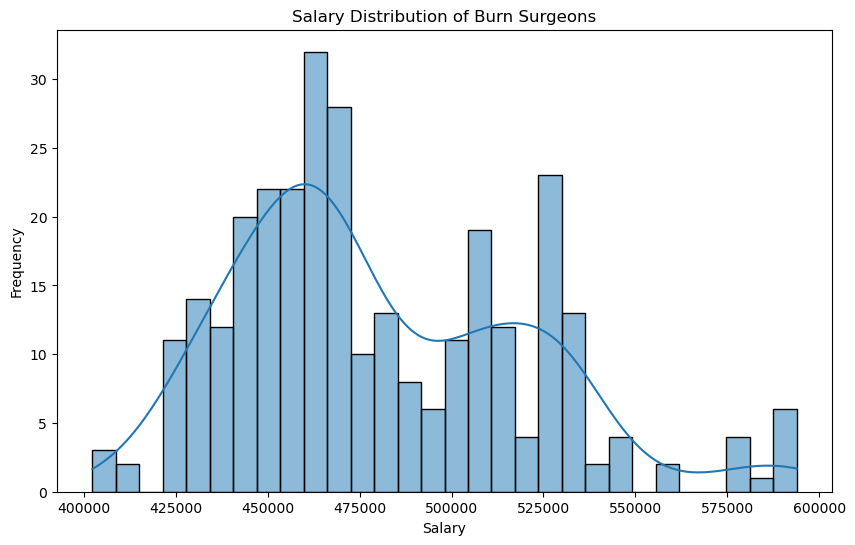

In [146]:

import matplotlib.pyplot as plt

def plot_salary_distribution(df, quintile_columns):
    """
    Plot the distribution of salaries for a given DataFrame and list of quintile columns.

    Args:
    df (pd.DataFrame): DataFrame containing salary data.
    quintile_columns (list): List of column names representing different salary quintiles.
    """
    df.reset_index(drop=True, inplace=True)
    # Flatten the DataFrame to get a list of all salary values across all quintiles
    all_salaries = df[quintile_columns].values.flatten()

    surgeon_type = df['Title'][1]
    # Plot the distribution of salaries
    plt.figure(figsize=(10, 6))
    sns.histplot(all_salaries, kde=True, bins=30)
    plt.title(f'Salary Distribution of {surgeon_type}s')
    plt.xlabel('Salary')
    plt.ylabel('Frequency')
    plt.show()

# Example usage:
# Assuming burn_surgeon_salary_cities is your DataFrame
# and it has columns like 'nTile10', 'nTile25', 'nTile50', 'nTile75', 'nTile90' representing salary quintiles
quintile_cols = ['nTile50']
plot_salary_distribution(burn_surgeon_salary_cities, quintile_cols)


In [17]:
def main(job_title):
    """Extract salary data from top us cities"""
    
    # get the list of largest us cities
    with open('largest_cities.csv', newline='') as f:
        reader = csv.reader(f)
        # a reader typically returns each row as a list... so I need to flatten the list to make a single list
        cities = [city for row in reader for city in row]
        
    # extract salary data for each city
    salary_data = []
    for city in cities:
        result = extract_salary_info(job_title, city)
        if result:
            salary_data.append(result)
            sleep(0.5)
            
    # save data to csv file
    with open('salary-results.csv', 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(['Title','Location', 'Description', 'nTile10', 'nTile25', 'nTile50', 'nTile75', 'nTile90'])
        writer.writerows(salary_data)
        
    return salary_data